# Coordinate Transformation of MITGCM data 

**Purpose**: Code for preforming the coordinate tranformation to along and across isobath coordinates 

**Luke Colosi | lcolosi@ucsd.edu**

Force matplotlib plots to display directly within the output cell of the notebook: 

In [6]:
%matplotlib inline

Import python libraries

In [7]:
import sys
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
from netCDF4 import Dataset, num2date
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import cmocean
from scipy.interpolate import splprep, splev
from pyproj import Proj, Transformer
from scipy.spatial import cKDTree
from scipy.interpolate import griddata

# Set path to access python functions
ROOT = '/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/'
sys.path.append(ROOT + 'AirSeaCoupling/tools/')

#--- Other Functions ---# 
import cartopy_figs as cart
from lsf import unweighted_lsf

Set data analysis parameters

In [9]:
# Set processing parameters
option_plot          = 1      # Specifies if supplementary plots are plotted
option_var           = 'temp' # Specifies which variable will analyzed. Options include: temp, sal, density, WVEL

# Set time and space parameters
T          = 1*(60)*(60)                   # Spcifies the time interval for model run. Units: seconds
isobath    = -2000                         # Specifies isobath depth contour. Units: m
ds, dn     = 1.5, 1.5                      # Specifies regular grid resolution. Units: km 
lat_bnds   = [33, 35]                      # Specifies the latitude bounds for the region to analyze
lon_bnds   = [-123 % 360, -120 % 360]      # Specifies the longitude bounds for the region to analyze
s_bnds     = [25, 175]                     # Specifies the along isobath bounds for the region to analyze
n_bnds     = [-40, 135]                    # Specifies the across isobath bounds for the region to analyze

# Set path to project directory
PATH = ROOT + 'AirSeaCoupling/data/mitgcm/SWOT_MARA_RUN4_LY/'
PATH_figs =  ROOT + 'AirSeaCoupling/figs_server/mitgcm/scale_analysis/'
PATH_bathy  = ROOT + 'AirSeaCoupling/data/bathymetry/'

# Set plotting parameters 
fontsize = 16

Load mitgcm data netcdf files 

In [10]:
#--- MITgcm Data ---# 
if option_var == 'temp':
    filename = PATH + "THETA_CCS4_hrly_ts_ext_depth_99.0m.nc"
elif option_var == 'sal':
    filename = PATH + "SALT_CCS4_hrly_ts_ext.nc"
elif option_var == 'density':
    filename = PATH + "RHO_CCS4_hrly_ts_ext.nc"
elif option_var == 'WVEL':
    filename = PATH + "WVEL_CCS4_hrly_ts_ext.nc"
nc = Dataset(filename, 'r')

# Extract data variables
water_depth   = nc.variables['Depth'][:]

lon = nc.variables['XC'][:]
lat = nc.variables['YC'][:]
time =  num2date(nc.variables['time'][:], nc.variables['time'].units)

if option_var == 'temp':
    data = nc.variables['THETA'][:]
elif option_var == 'sal':
    data = nc.variables['SALT'][:]
elif option_var == 'density':
    data = nc.variables['RHO'][:]
elif option_var == 'WVEL':
    data = nc.variables['WVEL'][:]

# Convert cftime.DatetimeGregorian to Python datetime objects
time_dt = np.array([datetime(d.year, d.month, d.day, d.hour, d.minute, d.second) for d in time])

Read in bathymetry data

In [11]:
# Load bathymetry data 
filename = PATH_bathy + "topo_25.1.nc"
ds_bathy = xr.open_dataset(filename, engine="netcdf4")

# Extract data variables
lon_b = ds_bathy["lon"]  # Longitude
lat_b = ds_bathy["lat"]  # Latitude
bathy = ds_bathy["z"]    # Elevation/Bathymetry

# Convert convesion of longitude (neg from the prime meridian to positive definite wrapping around the earth)
lon_n = lon_b % 360

# Set max and min values 
lon_min = lon_bnds[0]
lon_max = lon_bnds[1]
lat_min = lat_bnds[0]
lat_max = lat_bnds[1]

# Extract data from bathymetry 
lon_grid = lon_n[(lon_n >= lon_min) & (lon_n <= lon_max)]
lat_grid = lat_b[(lat_b >= lat_min) & (lat_b <= lat_max)]
bathy_grid   = bathy[(lat_b >= lat_min) & (lat_b <= lat_max),(lon_n >= lon_min) & (lon_n <= lon_max)]

Plot the spatial domain

/Users/lukecolosi/opt/anaconda3/envs/airsea_coupling/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'shading'
  result = super().contourf(*args, **kwargs)


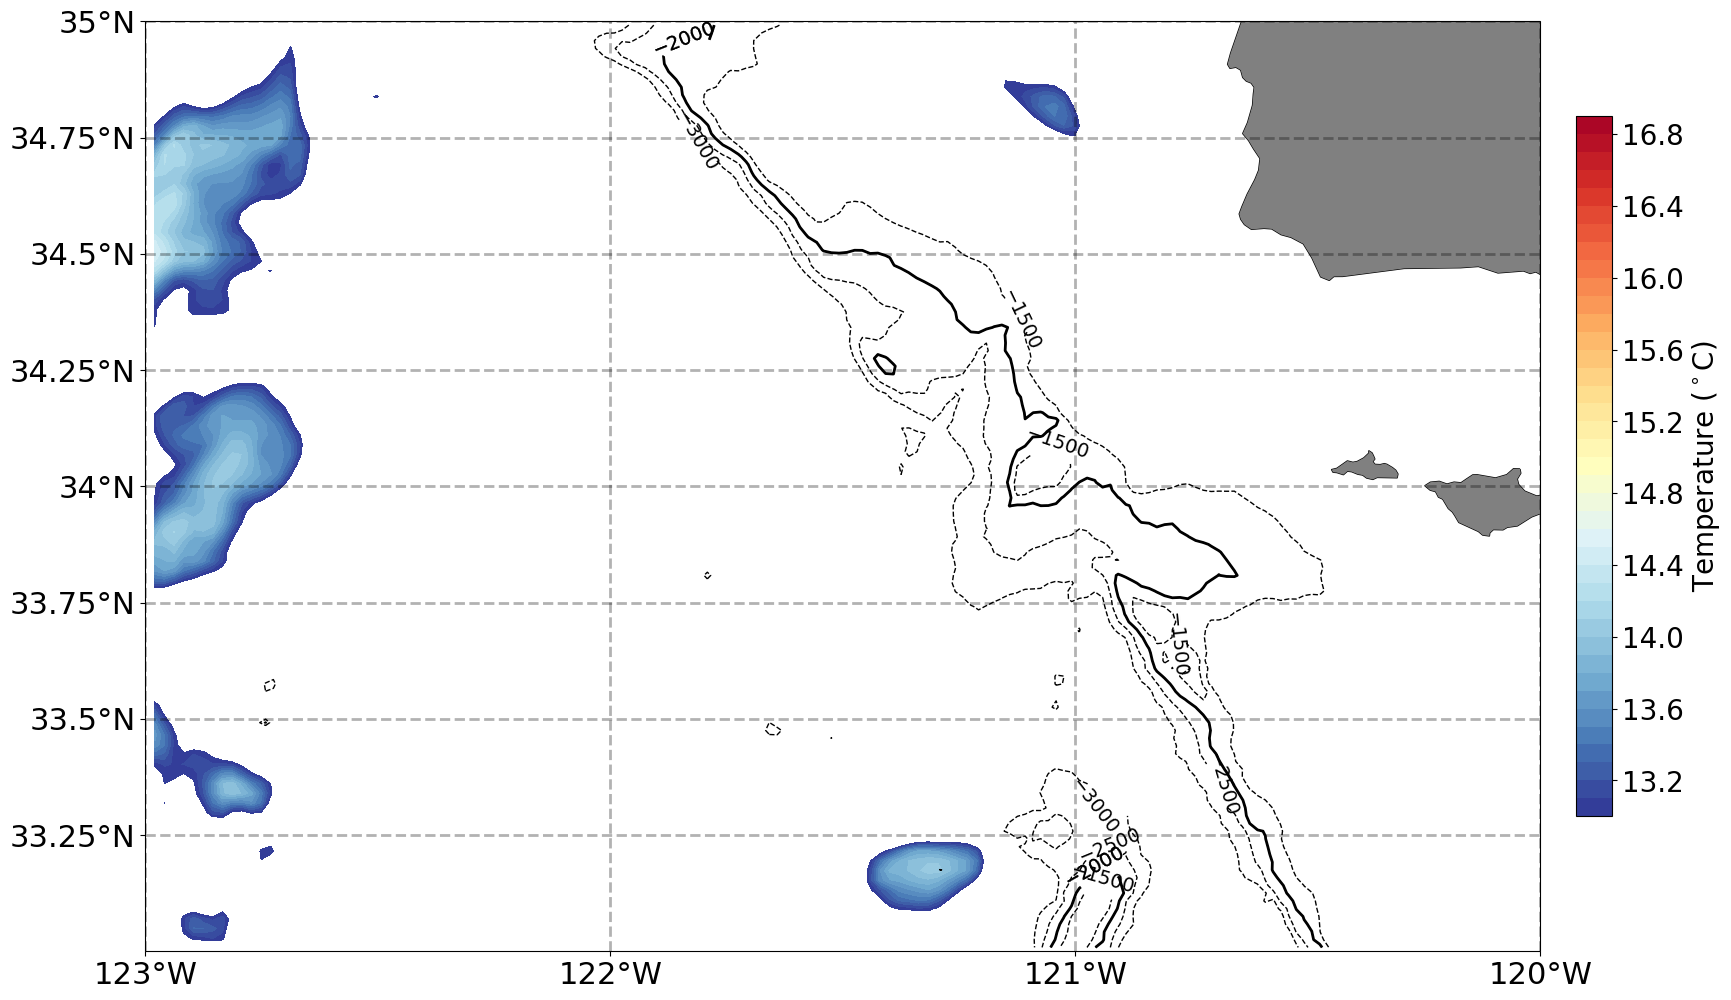

In [12]:
# Set plotting parameters
projection = ccrs.PlateCarree(central_longitude=0.0)
xticks = [-123, -122, -121, -120]
yticks = [33.25, 33.50, 33.75, 34.00, 34.25, 34.50, 34.75, 35.00]
resolution = "10m"
bounds = np.arange(0,360+40,40)
lon_min = -123
lon_max = -120
lat_min = 33
lat_max = 35

# Specify data specific attributes 
if option_var == 'temp':
    cmap = 'RdYlBu_r'
    label = r'Temperature ($^\circ$C)'
    levels = np.arange(13,17,0.1)
elif option_var == 'sal':
    cmap = 'BrBG_r'
    label = r'Salinity (psu)'
    levels = np.arange(32.85,33.75 + 0.02,0.02)
elif option_var == 'density': 
    cmap = 'Spectral_r'
    label = r'$\sigma_0$ (kg m$^{-3}$)'
    levels = np.arange(32.85,33.75 + 0.02,0.02)
elif option_var == 'WVEL': 
    cmap = cmocean.cm.deep_r
    label = r'$w$ (ms$^{-1}$)'
    levels = np.arange(5,8 + 0.1,0.1) * (10**(-5))

# Create figure
fig, axes = plt.subplots(1,1, figsize=(18, 20), subplot_kw={"projection": projection})

# Set figure axes 
cart.set_subplots(axes, projection, resolution, lon_min=lon_min, lon_max=lon_max, lat_min=lat_min, lat_max=lat_max) 

# Plot potential temperature
mesh = axes.contourf(
    lon, lat, data[1,:,:], levels=levels,
    transform=ccrs.PlateCarree(),
    cmap=cmap,  
    shading="auto"
)

# Plot depth contour lines
levels_bath = np.arange(-3000,-1000,500)
contour1 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=levels_bath, colors='black', linewidths=1, linestyles='dashed')
contour2 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=[-2000], colors='black', linewidths=2, linestyles='solid')
plt.clabel(contour1, fontsize=14)
plt.clabel(contour2, fontsize=14)

# Set grid ticks 
cart.set_grid_ticks(
    axes,
    projection=ccrs.PlateCarree(),
    xticks=xticks,
    yticks=yticks,
    xlabels=True,
    ylabels=True,
    grid=True,
    fontsize=22,
    color="black",
)

# Create colormap
cax = plt.axes([0.92, 0.33, 0.02, 0.35])
cart.set_cbar(
    mesh,
    cax,
    fig,
    orientation="vertical",
    extend="neither",
    cbar_label=label,
    nbins=10,
    fontsize=20,
    cbar_ticks=[],
    task="regular",
)

# Show the plot
plt.show()

# Save figure
fig.savefig(fname = PATH_figs + option_var + '_spatial_map_ts', bbox_inches = 'tight', dpi=300)

Remove the time mean and seasonal cycle from each grid point

In [13]:
# Set parameters
ntime,nlat,nlon = np.shape(data)
w1, w2 = [(2*np.pi)/31557600, (1/2)*(2*np.pi)/31557600]      # Radian Frequency for annual and semi-annual cycles. Units: rad/hr

# Convert to seconds since start time
t0 = time_dt[0]
time_elapsed = np.array([(t - t0).total_seconds() for t in time_dt])

# Initialize array
data_r = np.zeros((ntime,nlat,nlon))

# Loop through longitude
for ilon in range(0,nlon-1): 

    # Set progress bar
    progress = (ilon + 1) / (nlon-1)
    sys.stdout.write(f"\rProgress: {progress:.1%}")
    sys.stdout.flush()

    # Loop through latitude
    for ilat in range(0,nlat-1): 

        # Initialize the ith time series 
        data_ts = data[:,ilat,ilon]

        # Remove time mean and annual and semi-annual cycles 
        hfit, x_data, x_data_sigma, _ = unweighted_lsf(data_ts, time_elapsed, parameters = 2, freqs = np.array([w1,w2]), sigma = None)
        data_r[:,ilat,ilon] = data_ts - hfit


Progress: 100.0%

Extract the -2000 meter isobath contour positions

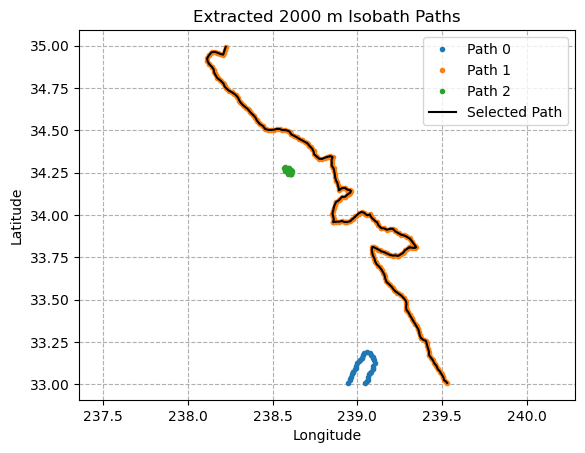

In [14]:
# Use contouring to extract the 1500 m isobath(s)
contour_set = plt.contour(lon_grid, lat_grid, bathy_grid, levels=[isobath])
plt.close()  # Prevents plot from displaying if you're in a notebook

# Extract all contour paths at the 1500 m level
paths = contour_set.allsegs[0] 

# Filter based on number of points (to exclude small closed loops like seamounts)
min_points = 100  # Adjust based on your resolution
valid_paths = [p for p in paths if len(p) > min_points]

# Select the longest or first valid path (shelf break usually shows up first)
selected_path = valid_paths[0]  # Or choose based on location

# Extract lon/lat from the path
lon_iso = selected_path[:, 0]
lat_iso = selected_path[:, 1]

# Plot the -2000 meter isobath contours and selected path
if option_plot == True:

    # Loop through paths
    for i, p in enumerate(paths):

        # Plot the ith contour path
        plt.plot(p[:, 0], p[:, 1], '.', label=f'Path {i}')

    # Plot the selected path 
    plt.plot(lon_iso,lat_iso, 'k-', label='Selected Path')

    # Set figure attributes
    plt.axis('equal')
    plt.grid(True,linestyle='--')
    plt.legend()
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Extracted 2000 m Isobath Paths")
    plt.show()

Convert the isobath coordinate to easting and northing coordinates

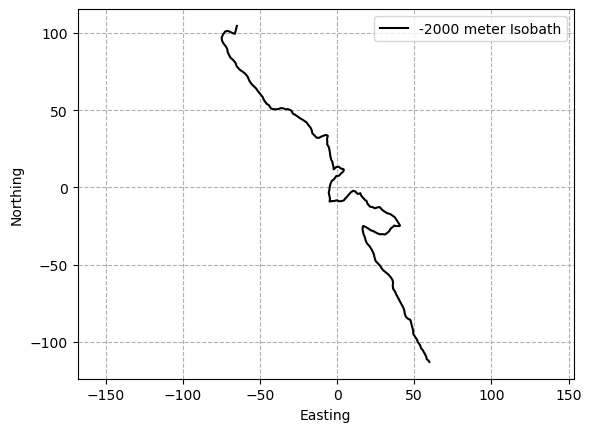

In [15]:
# Easting and Northing projection for the region, e.g., UTM zone 10N for California
transformer = Transformer.from_crs("epsg:4326", "epsg:32610", always_xy=True)  # WGS84 to UTM Zone 10N

# Convert lon/lat to x/y in meters
x_iso, y_iso = transformer.transform(lon_iso, lat_iso)

# Adjust isobath coordinates
x_iso_n, y_iso_n = (1/1000)* (x_iso - np.mean(x_iso)), (1/1000)* (y_iso - np.mean(y_iso)) 

# Plot the smoothed isobath in easting and northing coordinates
if option_plot == True:

    # Plot the unsmoothed and smoothed isobaths 
    plt.plot(x_iso_n,y_iso_n, 'k-', label='-2000 meter Isobath')

    # Set figure attributes
    plt.axis('equal')
    plt.grid(True,linestyle='--')
    plt.legend()
    plt.xlabel("Easting")
    plt.ylabel("Northing")
    plt.show()

Preform coordinate transform from $(x,y)$ to $(s,n)$ space 

In [16]:
####################################################
#--- Compute the tangent and normal vector ---# 
####################################################

# Fit a straight line to the bathymetry
m, b = np.polyfit(x_iso_n, y_iso_n, 1)  

# Compute the tangent vector 
t_vec = np.array([1, m])

# Normalize the tanget vector
t_hat = t_vec / np.linalg.norm(t_vec)

# Rotate 90° counter-clockwise to get normal vector
n_hat = np.array([t_hat[1], -t_hat[0]])

# Create a mesh grid of the longitude and latitude grid
LON,LAT = np.meshgrid(lon,lat)

# Flatten longitude and latitude coordinates for processing
lon_flat = LON.flatten()
lat_flat = LAT.flatten()

# Initialize data for 
data_l = []

# Loop through time
for itime in range(0,len(time)): 

    # Set progress bar
    progress = (itime + 1) / (len(time))
    sys.stdout.write(f"\rProgress: {progress:.1%}")
    sys.stdout.flush()

    ####################################################
    #--- Compute the tangent and normal coordinates ---# 
    ####################################################

    # Flatten data with annual/semi-annual cycle removed for processing
    data_flat = data_r[itime,:,:].flatten()

    # Convert the longitude and latitude coordinates into easting and northing coordinates
    x_flat, y_flat = transformer.transform(lon_flat, lat_flat)
    x_flat_km, y_flat_km = (1/1000) * (x_flat - np.mean(x_iso)), (1/1000) * (y_flat - np.mean(y_iso))

    # Choose the origin on the line 
    origin = np.array([x_iso_n[0], y_iso_n[0]])

    # Tranform data points into (s,n) coordinates
    points = np.stack([x_flat_km, y_flat_km], axis=-1) 
    deltas = points - origin  # vectors from origin to each point

    # Project onto tangent and normal directions
    s_coords = np.dot(deltas, t_hat)  # along-isobath (in units of input coords)
    n_coords = np.dot(deltas, n_hat)  # cross-isobath

    ####################################################
    #--- Crop data ---# 
    ####################################################

    # Crop data from just within a domain in the (s,n) space that has not land and constant boundaries
    idx_s = (s_coords >= s_bnds[0]) & (s_coords <= s_bnds[1])
    idx_n = (n_coords >= n_bnds[0]) & (n_coords <= n_bnds[1])
    idx = np.logical_and(idx_s, idx_n)
    s_crop, n_crop, data_crop = s_coords[idx], n_coords[idx], data_flat[idx]

    ####################################################
    #--- Map transformed data into a regular grid ---# 
    ####################################################

    # Choose your desired resolution
    s_min, s_max = s_crop.min(), s_crop.max()
    n_min, n_max = n_crop.min(), n_crop.max()

    # Set the grid coordinates
    s_grid = np.arange(s_min, s_max + ds, ds) - s_min
    n_grid = np.arange(n_min, n_max + dn, dn)

    # Reset the origin of s_grid
    s_crop_n = s_crop - s_min
    s_grid_n = s_grid - s_min

    # Set the meshgrid
    S, N = np.meshgrid(s_grid_n, n_grid)  # shape (Ny, Nx)

    # Flatten coordinates
    points = np.stack([s_crop_n, n_crop], axis=-1)  # shape (N, 2)

    # Interpolate SST onto grid
    data_grid = griddata(
        points, data_crop, (S, N),
        method='linear' 
    )

    ####################################################
    #--- Trim data so no NaNs are present ---# 
    ####################################################

    # Set NaNs to masked values
    mask = ~np.isnan(data_grid)
    
    # Find the rows and columns with at least one valid point
    row_inds = np.where(mask.any(axis=1))[0]
    col_inds = np.where(mask.any(axis=0))[0]

    # Trim the coordinates and data 
    data_trim = data_grid[row_inds[0]:row_inds[-1]+1, col_inds[0]:col_inds[-1]+1]
    S_trim = S[row_inds[0]:row_inds[-1]+1, col_inds[0]:col_inds[-1]+1]
    N_trim = N[row_inds[0]:row_inds[-1]+1, col_inds[0]:col_inds[-1]+1]

    # Identify valid rows
    row_nan_frac = np.isnan(data_trim).mean(axis=1)
    valid_rows = row_nan_frac <= 0

    # Apply the mask to keep only valid cross-isobath rows
    data_n = data_trim[valid_rows, :]
    S_n = S_trim[valid_rows, :]
    N_n = N_trim[valid_rows, :]

    ####################################################
    #--- Save data ---# 
    ####################################################
    
    # Save data from ith time step into an list 
    data_l.append(data_n.T)

    # Save coordinates
    if itime == 0: 
        s_m = S_n[1,:]
        n_m = N_n[:,1]
    

# Convert to 3D array (time, x, y)
data_m = np.stack(data_l, axis=0)

Progress: 100.0%

Save intermediate data

In [17]:
# Check if file exists, then delete it
file_path = PATH + "/mitgcm_coord_transform_sn_" + option_var  + "_isobath_" + str(abs(isobath)) + "_res_" + str(ds) + "_depth_99.0m.npz"
if os.path.exists(file_path):
    os.remove(file_path)

# Set metadata
metadata = {
    'description': 'MIT gcm model' + option_var + 'data transformed to along- and across-isobath coordinates at the ' + str(abs(isobath)) + ' isobath.',
    'source': 'MITgcm model data from SWOT_MARA_RUN4_LY',
    'coordinates units': 'km',
    'resolution': str(ds) + 'km'
}

# Save data arrays and metadata to a .npz file
np.savez(file_path, 
        data     = data_m,
        s        = s_m,
        n        = n_m,
        time     = time,
        metadata=metadata
        )

# Developmental Code

In [22]:
from matplotlib.animation import FuncAnimation, FFMpegWriter

# Set plotting parameters
projection = ccrs.PlateCarree(central_longitude=0.0)
xticks = [-124, -123, -122, -121, -120, -119]
yticks = [32.75, 33.00, 33.25, 33.50, 33.75, 34.00, 34.25, 34.50, 34.75,]
resolution = "10m"
cmap = plt.get_cmap('RdYlBu_r') 
bounds = np.arange(0,360+40,40)
lon_min = -124
lon_max = -119
lat_min = 32.50
lat_max = 35
levels = np.arange(13,17,0.1)
num_frames = 48

# Create figure
fig, ax = plt.subplots(1,1, figsize=(24, 20), subplot_kw={"projection": projection})

# Set figure axes 
cart.set_subplots(ax, projection, resolution, lon_min=-124, lon_max=-119, lat_min=32.50, lat_max=35)

# ---------------------
# Animation update function
# ---------------------
def update(frame, ds_subset, time, cmap, projection, resolution, levels, xticks, yticks, fig):

    # Update progress statement
    print(f"Rendering frame {frame}", flush=True)

    # Clear the axis to reset the plot
    ax.clear()

    # Redraw map features
    cart.set_subplots(ax, projection, resolution, lon_min=-124, lon_max=-119, lat_min=32.50, lat_max=35)

    # Add a dynamic title 
    ax.set_title(str(time[frame]),fontsize=20) # ax.set_title(f"Time Step: {time_step * frame} hours") 

    # Plot potential temperature
    mesh = ax.contourf(
        lon, lat, data[frame,:,:], levels=levels,
        transform=ccrs.PlateCarree(),
        cmap=cmap
    )

    # Plot depth contour lines
    levels_bath = np.arange(-3000,-1000,500)
    contour1 = ax.contour(lon_grid, lat_grid, bathy_grid,levels=levels_bath, colors='black', linewidths=1, linestyles='dashed')
    contour2 = ax.contour(lon_grid, lat_grid, bathy_grid,levels=[-2000], colors='black', linewidths=2, linestyles='solid')
    plt.clabel(contour1, fontsize=14)
    plt.clabel(contour2, fontsize=14)

    # Set grid ticks 
    cart.set_grid_ticks(
        ax,
        projection=ccrs.PlateCarree(),
        xticks=xticks,
        yticks=yticks,
        xlabels=True,
        ylabels=True,
        grid=True,
        fontsize=22,
        color="black",
    )

    # Create colormap
    cax = plt.axes([0.92, 0.33, 0.02, 0.35])
    cart.set_cbar(
        mesh,
        cax,
        fig,
        orientation="vertical",
        extend="neither",
        cbar_label=r"Temperature ($^\circ$C)",
        nbins=10,
        fontsize=20,
        cbar_ticks=[],
        task="regular",
    )

    return []

# ---------------------
# Create animation
# ---------------------
ani = FuncAnimation(fig, update, frames=num_frames, fargs=(data, time, cmap, projection, resolution, levels, xticks, yticks,fig), blit=False)

# ---------------------
# Save animation
# ---------------------
writer = FFMpegWriter(fps=10, metadata={'artist': 'Temperature time evolution map'})
ani.save(PATH_figs + 'temp_evolution_st_time_' + str(time[0])[0:4] + '_' + str(time[0])[5:7] + '_' + str(time[0])[8:10] + '.mp4', writer=writer)

Rendering frame 0
Rendering frame 0
Rendering frame 1
Rendering frame 2
Rendering frame 3
Rendering frame 4
Rendering frame 5
Rendering frame 6
Rendering frame 7
Rendering frame 8
Rendering frame 9
Rendering frame 10
Rendering frame 11
Rendering frame 12
Rendering frame 13
Rendering frame 14
Rendering frame 15
Rendering frame 16
Rendering frame 17
Rendering frame 18
Rendering frame 19
Rendering frame 20
Rendering frame 21
Rendering frame 22
Rendering frame 23
Rendering frame 24
Rendering frame 25
Rendering frame 26
Rendering frame 27
Rendering frame 28
Rendering frame 29
Rendering frame 30
Rendering frame 31
Rendering frame 32
Rendering frame 33
Rendering frame 34
Rendering frame 35
Rendering frame 36
Rendering frame 37
Rendering frame 38
Rendering frame 39
Rendering frame 40
Rendering frame 41
Rendering frame 42
Rendering frame 43
Rendering frame 44
Rendering frame 45
Rendering frame 46
Rendering frame 47
Rendering frame 0


In [26]:
from matplotlib.animation import FuncAnimation, FFMpegWriter

# Set plotting parameters
projection = ccrs.PlateCarree(central_longitude=0.0)
xticks = [-124, -123, -122, -121, -120, -119]
yticks = [32.75, 33.00, 33.25, 33.50, 33.75, 34.00, 34.25, 34.50, 34.75,]
resolution = "10m"
cmap = plt.get_cmap('RdYlBu_r') 
bounds = np.arange(0,360+40,40)
lon_min = -124
lon_max = -119
lat_min = 32.50
lat_max = 35
levels = np.arange(-2.2,0.4,0.1)
num_frames = 24

# Create figure
fig, ax = plt.subplots(1,1, figsize=(24, 20), subplot_kw={"projection": projection})

# Set figure axes 
cart.set_subplots(ax, projection, resolution, lon_min=-124, lon_max=-119, lat_min=32.50, lat_max=35)

# ---------------------
# Animation update function
# ---------------------
def update(frame, data_r, time, cmap, projection, resolution, levels, xticks, yticks, fig):

    # Update progress statement
    print(f"Rendering frame {frame}", flush=True)

    # Clear the axis to reset the plot
    ax.clear()

    # Redraw map features
    cart.set_subplots(ax, projection, resolution, lon_min=-124, lon_max=-119, lat_min=32.50, lat_max=35)

    # Add a dynamic title 
    ax.set_title(str(time[frame]),fontsize=20) # ax.set_title(f"Time Step: {time_step * frame} hours") 

    # Plot potential temperature
    mesh = ax.contourf(
        lon, lat, data_r[frame,:,:], levels=levels,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        extend='both'
    )

    # Plot depth contour lines
    levels_bath = np.arange(-3000,-1000,500)
    contour1 = ax.contour(lon_grid, lat_grid, bathy_grid,levels=levels_bath, colors='black', linewidths=1, linestyles='dashed')
    contour2 = ax.contour(lon_grid, lat_grid, bathy_grid,levels=[-2000], colors='black', linewidths=2, linestyles='solid')
    plt.clabel(contour1, fontsize=14)
    plt.clabel(contour2, fontsize=14)

    # Set grid ticks 
    cart.set_grid_ticks(
        ax,
        projection=ccrs.PlateCarree(),
        xticks=xticks,
        yticks=yticks,
        xlabels=True,
        ylabels=True,
        grid=True,
        fontsize=22,
        color="black",
    )

    # Create colormap
    cax = plt.axes([0.92, 0.33, 0.02, 0.35])
    cart.set_cbar(
        mesh,
        cax,
        fig,
        orientation="vertical",
        extend="both",
        cbar_label=r"Temperature ($^\circ$C)",
        nbins=10,
        fontsize=20,
        cbar_ticks=[],
        task="regular",
    )

    return []

# ---------------------
# Create animation
# ---------------------
ani = FuncAnimation(fig, update, frames=num_frames, fargs=(data_r, time, cmap, projection, resolution, levels, xticks, yticks,fig), blit=False)

# ---------------------
# Save animation
# ---------------------
writer = FFMpegWriter(fps=10, metadata={'artist': 'Temperature time evolution map'})
ani.save(PATH_figs + 'temp_evolution_no_annual_cycle_st_time_' + str(time[0])[0:4] + '_' + str(time[0])[5:7] + '_' + str(time[0])[8:10] + '.mp4', writer=writer)


Rendering frame 0
Rendering frame 0
Rendering frame 1
Rendering frame 2
Rendering frame 3
Rendering frame 4
Rendering frame 5
Rendering frame 6
Rendering frame 7
Rendering frame 8
Rendering frame 9
Rendering frame 10
Rendering frame 11
Rendering frame 12
Rendering frame 13
Rendering frame 14
Rendering frame 15
Rendering frame 16
Rendering frame 17
Rendering frame 18
Rendering frame 19
Rendering frame 20
Rendering frame 21
Rendering frame 22
Rendering frame 23
Rendering frame 0


Fit a Parametric Spline to the Isobath

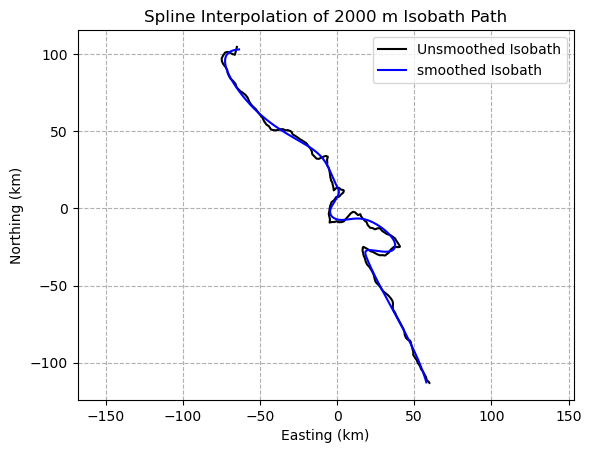

In [30]:
# Fit a spline to the isobath points
tck, u = splprep([x_iso_n, y_iso_n], s=10**3)  # Adjust 's' for smoothing (note that s scales with the )
unew = np.linspace(0, 1, 1000)
x_smooth, y_smooth = splev(unew, tck)

# Plot the raw and smoothed isobath contours and selected path
if option_plot == True:

    # Plot the unsmoothed and smoothed isobaths 
    plt.plot(x_iso_n,y_iso_n, 'k-', label='Unsmoothed Isobath')
    plt.plot(x_smooth,y_smooth, 'b-', label='smoothed Isobath')

    # Set figure attributes
    plt.axis('equal')
    plt.grid(True,linestyle='--')
    plt.legend()
    plt.xlabel("Easting (km)")
    plt.ylabel("Northing (km)")
    plt.title("Spline Interpolation of 2000 m Isobath Path")
    plt.show()

Compute Tangent and Normal Vectors

**Note**: Here we define the tangent and normal vectors by the following.

Let the position vector for the isobath be defined as: 

$$
r(u) = 
\begin{bmatrix}
x(u) \\
y(u)
\end{bmatrix}
$$

where $x$ and $y$ are the easting and northing coordinates along the isobath and $u \in (0,1)$ is the parameter along the isobath. The tanget vector $t(u)$ is the derivative of $r(u)$ with respect to u: 

$$
t(u) = \frac{d\textbf{r}}{du} = 
\begin{bmatrix}
\frac{dx}{du} \\
\frac{dy}{du}
\end{bmatrix}
$$

The unit tangent vector $\hat{t}(u)$ is then the tangent vector $t(u)$ normalized by its magnitude: 

$$
\hat{t}(u) = \frac{t(u)}{\lvert\lvert t(u) \rvert\rvert} = \frac{1}{\sqrt{(\frac{dx}{du} )^2 + (\frac{dy}{du} )^2}} \cdot 
\begin{bmatrix}
\frac{dx}{du} \\
\frac{dy}{du}
\end{bmatrix}
$$

The normal vector $\hat{n}(u)$ is a unit vector perpendicular to $\hat{t}(u)$. You can get it by rotating the tangent vector by 90 degrees clockwise:

$$
\hat{n}(u) = R\bigg(\theta = -\frac{\pi}{2}\bigg) \cdot \hat{t}(u) = 
\begin{bmatrix}
\cos(-\frac{\pi}{2}) & -\sin(-\frac{\pi}{2}) \\
\sin(-\frac{\pi}{2}) & \cos(-\frac{\pi}{2})
\end{bmatrix}
\cdot 
\begin{bmatrix}
\hat{t}_x \\
\hat{t}_y
\end{bmatrix} 
= 
\begin{bmatrix}
\hat{t}_y \\
-\hat{t}_x
\end{bmatrix} 
$$

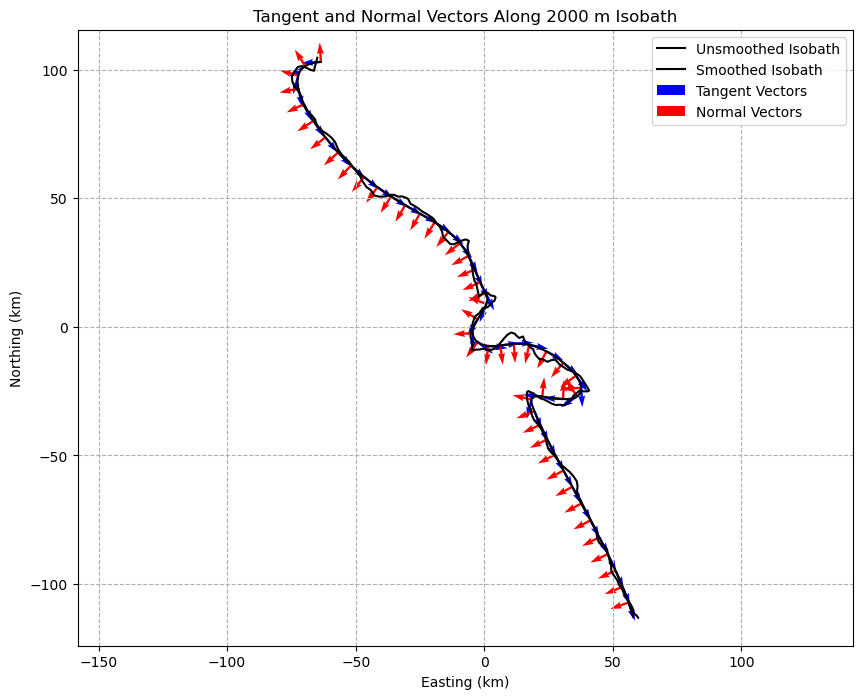

In [34]:
# Compute first derivatives (tangent vectors)
dx_du, dy_du = splev(unew, tck, der=1)

# Normalize tangent vectors
magnitude = np.hypot(dx_du, dy_du)
t_hat = np.vstack((dx_du / magnitude, dy_du / magnitude))

# Compute normal vectors by rotating tangent vectors 90 degrees clockwise
n_hat = np.vstack((t_hat[1], -t_hat[0]))

# Plot the tangent and normal vectors
if option_plot == True: 

    # Example: sample every Nth point to avoid clutter
    stride = 20  # or 10, depending on spacing

    # Plot the isobath
    plt.figure(figsize=(10, 8))
    plt.plot(x_iso_n,y_iso_n, 'k-', label='Unsmoothed Isobath')
    plt.plot(x_smooth, y_smooth, 'k-', label='Smoothed Isobath')

    # Plot tangent vectors
    plt.quiver(
        x_smooth[::stride], y_smooth[::stride],  # positions
        t_hat[0,::stride], t_hat[1,::stride],  # dx, dy
        color='blue', scale=40, width=0.003, label='Tangent Vectors'
    )

    # Plot normal vectors
    plt.quiver(
        x_smooth[::stride], y_smooth[::stride],  # positions
        n_hat[0,::stride], n_hat[1,::stride],  # dx, dy
        color='red', scale=40, width=0.003, label='Normal Vectors'
    )

    plt.axis('equal')
    plt.xlabel('Easting (km)')
    plt.ylabel('Northing (km)')
    plt.title('Tangent and Normal Vectors Along 2000 m Isobath')
    plt.legend()
    plt.grid(True,linestyle='--')
    plt.show()

Compute the arc length along the isobath for the s-coordinate

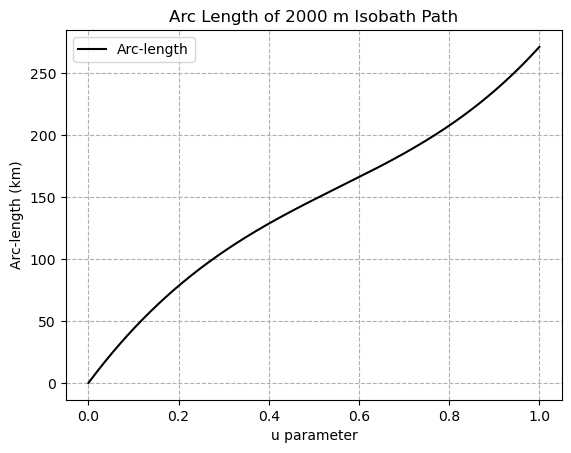

In [26]:
# Compute segment-wise distances
dx = np.diff(x_smooth)
dy = np.diff(y_smooth)
ds = np.sqrt(dx**2 + dy**2)  # segment lengths in km

# Arc length: cumulative sum of segment lengths
arc_length = np.concatenate(([0], np.cumsum(ds)))  # s[0] = 0, units: km

# Plot the raw and smoothed isobath contours and selected path
if option_plot == True:

    # Plot the arc-length as a function of u
    plt.plot(unew,arc_length, 'k-', label='Arc-length')

    # Set figure attributes
    plt.grid(True,linestyle='--')
    plt.legend()
    plt.xlabel("u parameter")
    plt.ylabel("Arc-length (km)")
    plt.title("Arc Length of 2000 m Isobath Path")
    plt.show()

Project the data onto the $(s, n)$ Coordinate System

In [27]:
from scipy.spatial import cKDTree

# Create a mesh grid of the longitude and latitude grid
LON,LAT = np.meshgrid(lon,lat)

# Flatten SST data for processing
lon_flat = LON.flatten()
lat_flat = LAT.flatten()
data_flat = data[1,:,:].flatten()

# Convert the longitude and latitude coordinates into easting and northing coordinates
x_flat, y_flat = transformer.transform(lon_flat, lat_flat)
x_flat_km, y_flat_km = (x_flat - np.mean(x_iso))/1000, (y_flat - np.mean(y_iso))/1000

# Build a KD-tree for the isobath points
isobath_points = np.vstack((x_smooth, y_smooth)).T
tree = cKDTree(isobath_points)

# Query the nearest isobath point for each SST point
data_points = np.vstack((x_flat_km, y_flat_km)).T
distances, indices = tree.query(data_points)

# Compute s (along-isobath) and n (cross-isobath) coordinates
s_coords = arc_length[indices]  # Along-isobath distances

# Compute vectors from isobath points to SST points
delta_x = x_flat_km - x_smooth[indices]
delta_y = y_flat_km - y_smooth[indices]

# Compute cross-isobath distances using normal vectors
n_coords = delta_x * n_hat[0, indices] + delta_y * n_hat[1, indices]

Plot the data in the new coordinate system 

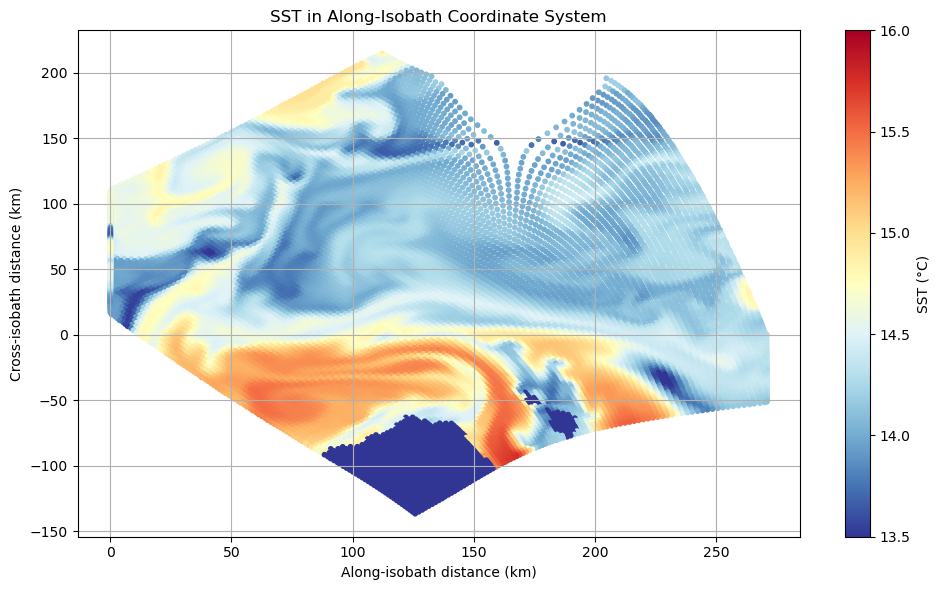

In [28]:
plt.figure(figsize=(10, 6))
sc = plt.scatter(s_coords, n_coords, c=data_flat, cmap='RdYlBu_r', s=10, vmin=13.5, vmax=16)
plt.colorbar(sc, label='SST (°C)')
plt.xlabel('Along-isobath distance (km)')
plt.ylabel('Cross-isobath distance (km)')
plt.title('SST in Along-Isobath Coordinate System')
plt.grid(True)
plt.tight_layout()
plt.show()

Preform the coordinate tranform on a linear fit to the bathymetry 

In [16]:
# Fit a straight line to the bathymetry
m, b = np.polyfit(x_iso_n, y_iso_n, 1)  # hfit, x_data, _, _ = unweighted_lsf(y_iso_n, x_iso_n, 0, [], [])

# Compute the tangent vector 
t_vec = np.array([1, m])

# Normalize the tanget vector
t_hat = t_vec / np.linalg.norm(t_vec)

# Rotate 90° counter-clockwise to get normal vector
n_hat = np.array([t_hat[1], -t_hat[0]])

# Create a mesh grid of the longitude and latitude grid
LON,LAT = np.meshgrid(lon,lat)

# Flatten SST data for processing
lon_flat = LON.flatten()
lat_flat = LAT.flatten()
data_flat = data[1,:,:].flatten()

# Convert the longitude and latitude coordinates into easting and northing coordinates
x_flat, y_flat = transformer.transform(lon_flat, lat_flat)
x_flat_km, y_flat_km = (x_flat - np.mean(x_iso))/1000, (y_flat - np.mean(y_iso))/1000

# Choose the origin on the line 
origin = np.array([x_iso_n[0], y_iso_n[0]])

# Tranform data points into (s,n) coordinates
points = np.stack([x_flat_km, y_flat_km], axis=-1) 
deltas = points - origin  # vectors from origin to each point

# Project onto tangent and normal directions
s_coords = np.dot(deltas, t_hat)  # along-isobath (in units of input coords)
n_coords = np.dot(deltas, n_hat)  # cross-isobath

Plot the bathymetry with linear fit

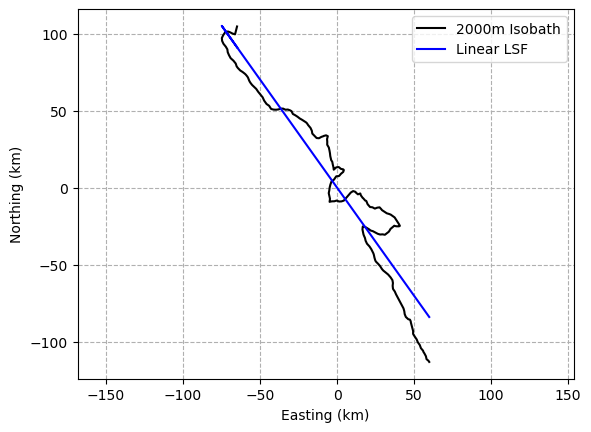

In [17]:
# Compute the linear fit line 
bfit = m*(x_iso_n) + b

# Plot the isobath and linear fit 
plt.plot(x_iso_n,y_iso_n, 'k-', label='2000m Isobath')
plt.plot(x_iso_n,bfit, 'b-', label='Linear LSF')

# Set figure attributes
plt.axis('equal')
plt.grid(True,linestyle='--')
plt.legend()
plt.xlabel("Easting (km)")
plt.ylabel("Northing (km)")
plt.show()

Plot the coordinate transformed data in the new coordinate system 

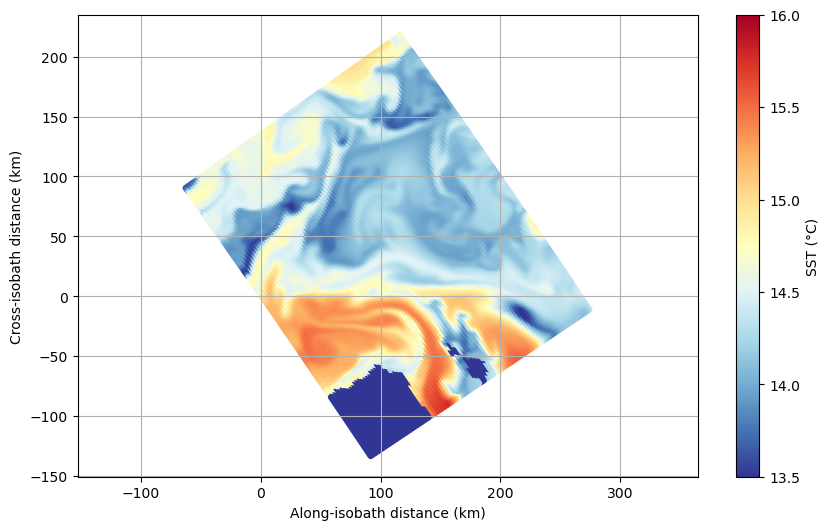

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(s_coords, n_coords, c=data_flat, cmap='RdYlBu_r', s=15, vmin=13.5, vmax=16)
plt.colorbar(label='SST (°C)')
plt.xlabel('Along-isobath distance (km)')
plt.ylabel('Cross-isobath distance (km)')
#plt.title('Data in Straight-Line Isobath Coordinate System')
plt.axis('equal')
plt.grid(True)
plt.show()

Crop the domain so the domain does not contain land and constant boundaries


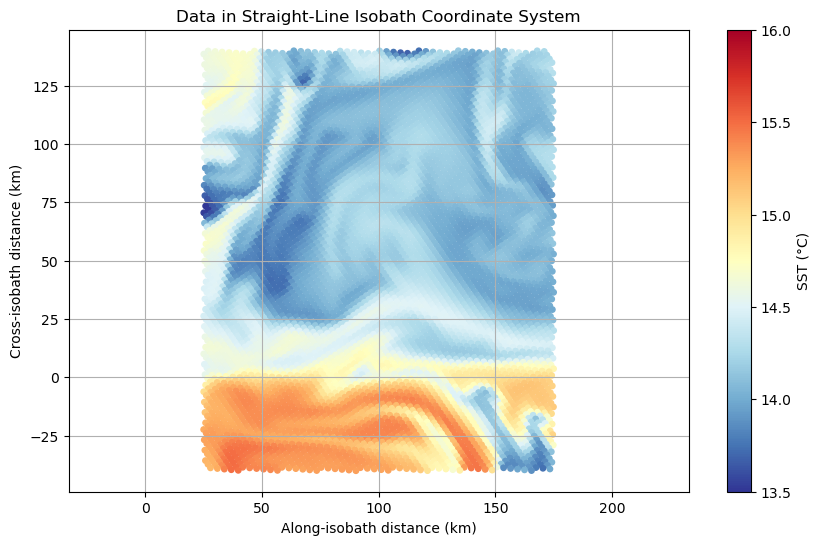

In [19]:
# Crop data from just within a domain in the (s,n) space that has not land and constant boundaries
# idx_s = (s_coords >= 27) & (s_coords <= 174)
# idx_n = (n_coords >= -40) & (n_coords <= 135)
idx_s = (s_coords >= 25) & (s_coords <= 175)
idx_n = (n_coords >= -40) & (n_coords <= 140)
idx = np.logical_and(idx_s, idx_n)
s_crop, n_crop, data_crop = s_coords[idx], n_coords[idx], data_flat[idx]

# Plot the data in the new coordinate system 
plt.figure(figsize=(10, 6))
plt.scatter(s_crop, n_crop, c=data_crop, cmap='RdYlBu_r', s=15, vmin=13.5, vmax=16)
plt.colorbar(label='SST (°C)')
plt.xlabel('Along-isobath distance (km)')
plt.ylabel('Cross-isobath distance (km)')
plt.title('Data in Straight-Line Isobath Coordinate System')
plt.axis('equal')
plt.grid(True)
plt.show()

Now let's put the data back on a regular grid in (s,n) space

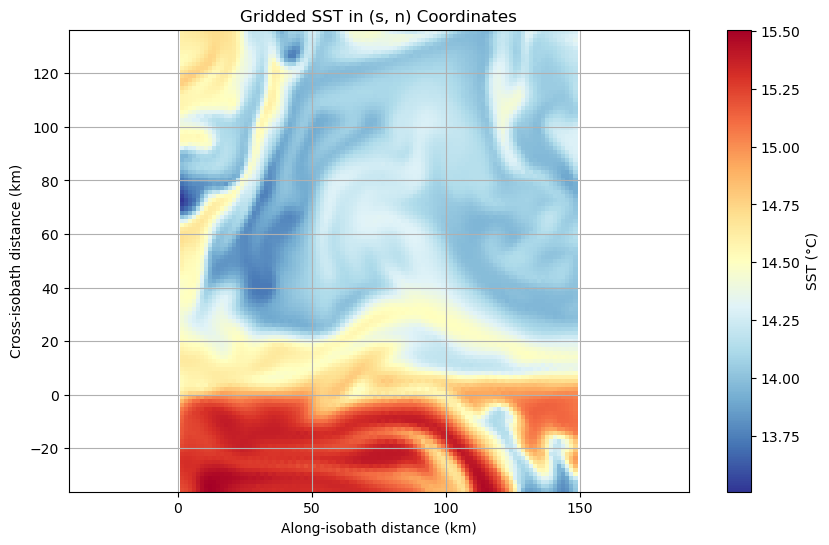

In [21]:
# Choose your desired resolution
s_min, s_max = s_crop.min(), s_crop.max()
n_min, n_max = n_crop.min(), n_crop.max()

# Define regular grid
ds = 1.5  # Units: km (or adjust for your resolution)
dn = 1.5

# Set the grid 
s_grid = np.arange(s_min, s_max + ds, ds) 
n_grid = np.arange(n_min, n_max + dn, dn)

# Reset the origin of s_grid
s_crop_n = s_crop - s_min
s_grid_n = s_grid - s_min

# Set the meshgrid
S, N = np.meshgrid(s_grid_n, n_grid)  # shape (Ny, Nx)

# Flatten coordinates
points = np.stack([s_crop_n, n_crop], axis=-1)  # shape (N, 2)

# Interpolate SST onto grid
data_grid = griddata(
    points, data_crop, (S, N),
    method='linear'  # or 'cubic', or 'nearest'
)

# Set NaNs to masked values
mask = ~np.isnan(data_grid)

# Find the rows and columns with at least one valid point
row_inds = np.where(mask.any(axis=1))[0]
col_inds = np.where(mask.any(axis=0))[0]

# Trim the coordinates and data 
data_trim = data_grid[row_inds[0]:row_inds[-1]+1, col_inds[0]:col_inds[-1]+1]
S_trim = S[row_inds[0]:row_inds[-1]+1, col_inds[0]:col_inds[-1]+1]
N_trim = N[row_inds[0]:row_inds[-1]+1, col_inds[0]:col_inds[-1]+1]

# Identify valid rows
row_nan_frac = np.isnan(data_trim).mean(axis=1)
valid_rows = row_nan_frac <= 0

# Apply the mask to keep only valid cross-isobath rows
data_n = data_trim[valid_rows, :]
S_n = S_trim[valid_rows, :]
N_n = N_trim[valid_rows, :]

# Plot final product
plt.figure(figsize=(10, 6))
plt.pcolormesh(S_n, N_n, data_n, cmap='RdYlBu_r', shading='Auto')
plt.colorbar(label='SST (°C)')
plt.xlabel('Along-isobath distance (km)')
plt.ylabel('Cross-isobath distance (km)')
plt.title('Gridded SST in (s, n) Coordinates')
plt.axis('equal')
plt.grid(True)
plt.show()